# SYSC4906 Assignment 3 Rough Work

**Group Name: Simon and Rachel** 

**Student names: Simon Dewilde & Rachel Myrah**

**Student numbers: 101004413 & 101002836** 


# Model Training
## Step 1: Load the image dataset and split it
 * Create _TRAIN_ and _TEST_ directories with building code directories inside
 * Flip images to be right up based on EXIF data (Orientation/Rotation)
 * Resize all images to 299x299 for training
 * Copy 90% of images to _TRAIN_ (keeping in building code directories)
 * Copy remaining 10% of images to _TEST_

In [0]:
from glob import glob
import os
import shutil
from PIL import Image, ExifTags

# Get exif orientation keys
for orientation in ExifTags.TAGS.keys() : 
  if ExifTags.TAGS[orientation]=='Orientation' : break 
for rotation in ExifTags.TAGS.keys() : 
  if ExifTags.TAGS[rotation]=='Rotation' : break

def augment_orientation_and_size(path):
  im = Image.open(path)
  if im._getexif() is not None:
    exif=dict(im._getexif().items())
    if orientation in exif.keys():
      if exif[orientation] == 3 : 
        im=im.rotate(180, expand=True)
      elif exif[orientation] == 6 : 
        im=im.rotate(270, expand=True)
      elif exif[orientation] == 8 : 
        im=im.rotate(90, expand=True)
    elif rotation in exif.keys():
      im=im.rotate(exif[rotation])
  im = im.resize((299, 299), Image.ANTIALIAS)
  im.save(path)

# This needs to be the name of the zip what has the 500x500 images
!unzip 4906_Images.zip
!mkdir TRAIN
!mkdir TEST

buildingCodes = ('AA', 'CB', 'CT', 'DT', 'FH', 'HP', 'HS', 'LB', 'MC', 'ME', 'ML', 'PA', 'RB', 'RO', 'SA', 'TB')

# Make all of the folders needed for train and test
for directory in ["TRAIN", "TEST"]:
  for building in buildingCodes:
    try:
      os.mkdir(os.path.join(directory, building))
    except FileExistsError:
      pass #Probably already ran this bit

# Get all the images sorted in a dictonary by code
raw_photos_dict = dict()
for i in range(16):
  raw_photos_dict[buildingCodes[i]] = glob("All_Images_500x500/" + buildingCodes[i] + "/*.jpg")

# Copy 90% of images into it's train folder (10% into test)
for directory in ["TRAIN", "TEST"]:
  for building in buildingCodes:
    files = raw_photos_dict[building]
    if directory == "TRAIN":
      for i in range(int(len(files) * 0.9)):
        augment_orientation_and_size(os.path.join(files[i]))
        shutil.copyfile(os.path.join(files[i]), os.path.join(directory, building, os.path.basename(files[i])))
    else:
      for i in range(int(len(files) * 0.1)):
        augment_orientation_and_size(os.path.join(files[-i - 1]))
        shutil.copyfile(os.path.join(files[-i - 1]), os.path.join(directory, building, os.path.basename(files[-i - 1])))

# Make train and test lists for later use
train_photos_list = [0] * 16
test_photos_list = [0] * 16
for i in range(len(train_photos_list)):
  train_photos_list[i] = glob("TRAIN/" + buildingCodes[i] + "/*.jpg")
for i in range(len(test_photos_list)):
  test_photos_list[i] = glob("TEST/" + buildingCodes[i] + "/*.jpg")

## Step 2: Show images
 * Shows the first image for each building in the training data


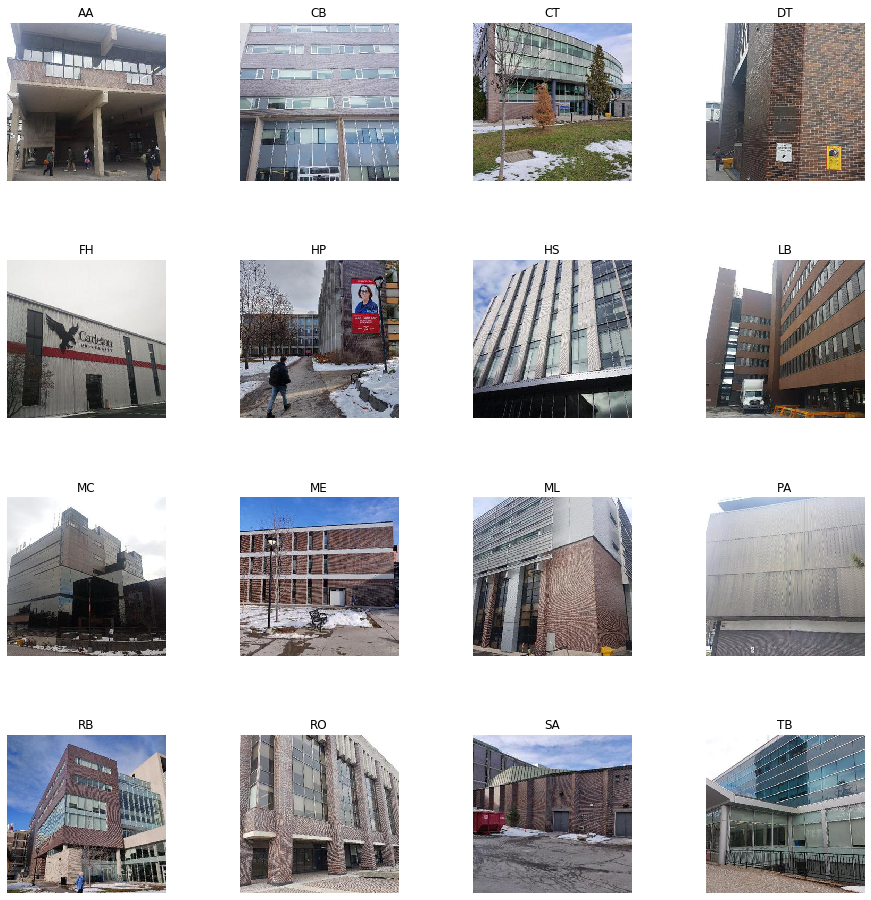

In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)
for i in range(len(raw_photos_dict)):
  fig.add_subplot(4, 4, i + 1)
  plt.title(buildingCodes[i])
  plt.imshow(Image.open(train_photos_list[i][0]))
  plt.axis('off')

##Step 3: Create model
 * Import `Xception` model from `Keras` with random weights
 * Include top layer and set classes to 16
 * Compile with the following settings
  * Optimizer: adam
  * Loss: categorical cross-entropy
  * Metrics: accuracy and categorical accuracy

In [0]:
from keras.models import Model
from keras.applications.xception import Xception, preprocess_input

CLASSES = 16
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32
    
transfer_xception_model = Xception(weights=None, include_top=True, classes=CLASSES)
transfer_xception_model.compile(optimizer='adam',
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy', 'categorical_accuracy'])

## Step 4: Prepare train and test data
 * Create image data generators for test and training
 * Set up with the following options
  * Width shift: 0.3
  * Height shift: 0.3
  * Fill mode: nearest
  * Rotation range: 20 degrees
  * Zoom range: 0.3
  * Vertical flips

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=20,
    zoom_range=0.3,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=20,
    zoom_range=0.3,
    vertical_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    "TRAIN",
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
test_generator = test_datagen.flow_from_directory(
    "TEST",
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 3014 images belonging to 16 classes.
Found 328 images belonging to 16 classes.


## Step 5: Train model
 * Train model created in Step 3
 * Run for 75 epochs, 100 steps per epoch
 * Run 10 validation steps per epoch
 * Checkpoint only best models based on validation accuracy
 * Shuffle data being passed to the trainer

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

EPOCHS = 75
STEPS_PER_EPOCH = 100
test_length = sum(len(x) for x in test_photos_list)
VALIDATION_STEPS = int(test_length / BATCH_SIZE) # Recommended size by Keras
CHECKPOINT_PATH = "carleton-buildings-xception-v5-{epoch:02d}-{val_acc:.2f}.hdf5"

mcp = ModelCheckpoint(CHECKPOINT_PATH, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

history = transfer_xception_model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    shuffle=True,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[mcp])


#Required functions and the code that lead to their values
Below is the way that the best precision and worst recall was calculated using all images available

## prepareModel()
Downloads the best model found from training via github and loads it


In [0]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model
import os

buildingCodes = ('AA', 'CB', 'CT', 'DT', 'FH', 'HP', 'HS', 'LB', 'MC', 'ME', 'ML', 'PA', 'RB', 'RO', 'SA', 'TB')

def prepareModel():
  global model
  !wget https://github.com/wsimond49/Carleton_Building_Identification_ML/blob/master/carleton-buildings-xception-model.hdf5?raw=true
  if os.path.exists("carleton-buildings-xception-model.hdf5?raw=true"):
    model = load_model("carleton-buildings-xception-model.hdf5?raw=true")
  else:
    print("MODEL WAS NOT DOWNLOADED CORRECTLY FROM GITHUB")
    print("Download model from github.com/wsimond49/Carleton_Building_Identification_ML")
    print("Upload it here and rename it as carleton-buildings-xception-model.hdf5?raw=true")
    exit(1)


## label = classifyImage(fname)
Takes in file name and classifies image
 * Loads image
 * Resizes image for network input
 * Normalize image values as preprocessing
 * Return building with highest score


In [0]:
def classifyImage(fname):
  global model 
  image = Image.open(fname)
  image = image.resize((299, 299), Image.ANTIALIAS)
  image = np.asarray(image)
  image = image.astype('float32')
  image = image/255
  prediction = model.predict(np.expand_dims(image, axis=0))[0].tolist()
  return buildingCodes[prediction.index(max(prediction))]


## label = worstRecall()
This is how we actually calculated the worst recall in the final product

Runs through all images in 500x500 folder and keeps track of true positives for each building

Returns the building that has the lowest recall score

In [0]:
def worstRecall():
  true_positive = [0] * 16
  for i in range(16):
    building_name = buildingCodes[i]
    for j in range(len(raw_photos_dict[buildingCodes[i]])):
      pred = classifyImage(raw_photos_dict[buildingCodes[i]][j])
      if pred == building_name:
        true_positive[i] += 1

  worst_building = ""
  worst_recall = 100
  for i in range(16):
    if true_positive[i] == 0:
      recall = 0
    else:
      recall = true_positive[i] / len(raw_photos_dict[buildingCodes[i]])
    if recall < worst_recall:
      worst_recall = recall
      worst_building = buildingCodes[i]

  return worst_building

## label = bestPrecision()
This is how we actually calculated the best precision used in the final product

Runs through all images in 500x500 folder and keeps track of true positives and false positives for each building

Returns the building that has the highest precision score

In [0]:
def bestPrecision():
  true_positive = [0] * 16
  false_positive = [0] * 16
  for i in range(16):
    building_name = buildingCodes[i]
    for j in range(len(raw_photos_dict[buildingCodes[i]])):
      pred = classifyImage(raw_photos_dict[buildingCodes[i]][j])
      if pred == building_name:
        true_positive[i] += 1
      else:
        false_positive[buildingCodes.index(pred)] += 1

  best_building = ""
  best_precision = 0
  for i in range(16):
    if true_positive[i] == 0:
      precision = 0
    else:
      precision = true_positive[i] / (true_positive[i] + false_positive[i])
    if precision > best_precision:
      best_precision = precision
      best_building = buildingCodes[i]
  
  return best_building


##acc_score = estimatedAccuracy()
Purely based on the values given by `Keras` during training in the validation accuracy field

See full training output below.  The selected model is take at epoch 64 as it has the highest validation accuracy

In [0]:
def estimatedAccuracy():
  return 0.9696

# Training output
 * See far right of each line for validation accuracy
 
```
Epoch 1/75
100/100 [==============================] - 88s 881ms/step - loss: 2.4602 - acc: 0.2150 - categorical_accuracy: 0.2150 - val_loss: 12.9411 - val_acc: 0.1437 - val_categorical_accuracy: 0.1437
Epoch 2/75
100/100 [==============================] - 85s 848ms/step - loss: 1.9018 - acc: 0.3920 - categorical_accuracy: 0.3920 - val_loss: 7.5173 - val_acc: 0.2095 - val_categorical_accuracy: 0.2095
Epoch 3/75
100/100 [==============================] - 85s 846ms/step - loss: 1.5703 - acc: 0.5070 - categorical_accuracy: 0.5070 - val_loss: 10.3360 - val_acc: 0.1689 - val_categorical_accuracy: 0.1689
Epoch 4/75
100/100 [==============================] - 85s 851ms/step - loss: 1.2512 - acc: 0.6057 - categorical_accuracy: 0.6057 - val_loss: 10.5440 - val_acc: 0.1250 - val_categorical_accuracy: 0.1250
Epoch 5/75
100/100 [==============================] - 85s 847ms/step - loss: 1.0514 - acc: 0.6796 - categorical_accuracy: 0.6796 - val_loss: 2.6103 - val_acc: 0.4932 - val_categorical_accuracy: 0.4932
Epoch 6/75
100/100 [==============================] - 85s 847ms/step - loss: 0.8945 - acc: 0.7253 - categorical_accuracy: 0.7253 - val_loss: 4.3044 - val_acc: 0.3953 - val_categorical_accuracy: 0.3953
Epoch 7/75
100/100 [==============================] - 84s 844ms/step - loss: 0.7886 - acc: 0.7588 - categorical_accuracy: 0.7588 - val_loss: 2.2911 - val_acc: 0.5372 - val_categorical_accuracy: 0.5372
Epoch 8/75
100/100 [==============================] - 83s 826ms/step - loss: 0.6865 - acc: 0.7884 - categorical_accuracy: 0.7884 - val_loss: 5.4883 - val_acc: 0.2399 - val_categorical_accuracy: 0.2399
Epoch 9/75
100/100 [==============================] - 83s 834ms/step - loss: 0.6772 - acc: 0.7951 - categorical_accuracy: 0.7951 - val_loss: 1.1792 - val_acc: 0.7027 - val_categorical_accuracy: 0.7027
Epoch 10/75
100/100 [==============================] - 82s 822ms/step - loss: 0.4926 - acc: 0.8502 - categorical_accuracy: 0.8502 - val_loss: 0.7454 - val_acc: 0.7939 - val_categorical_accuracy: 0.7939
Epoch 11/75
100/100 [==============================] - 82s 821ms/step - loss: 0.5330 - acc: 0.8397 - categorical_accuracy: 0.8397 - val_loss: 0.7796 - val_acc: 0.7669 - val_categorical_accuracy: 0.7669
Epoch 12/75
100/100 [==============================] - 83s 828ms/step - loss: 0.4605 - acc: 0.8680 - categorical_accuracy: 0.8680 - val_loss: 0.7841 - val_acc: 0.7625 - val_categorical_accuracy: 0.7625
Epoch 13/75
100/100 [==============================] - 86s 859ms/step - loss: 0.4175 - acc: 0.8681 - categorical_accuracy: 0.8681 - val_loss: 1.7553 - val_acc: 0.5912 - val_categorical_accuracy: 0.5912
Epoch 14/75
100/100 [==============================] - 86s 858ms/step - loss: 0.4244 - acc: 0.8816 - categorical_accuracy: 0.8816 - val_loss: 0.5724 - val_acc: 0.8615 - val_categorical_accuracy: 0.8615
Epoch 15/75
100/100 [==============================] - 84s 845ms/step - loss: 0.3489 - acc: 0.8950 - categorical_accuracy: 0.8950 - val_loss: 0.7304 - val_acc: 0.7973 - val_categorical_accuracy: 0.7973
Epoch 16/75
100/100 [==============================] - 85s 845ms/step - loss: 0.3764 - acc: 0.8822 - categorical_accuracy: 0.8822 - val_loss: 0.7261 - val_acc: 0.8007 - val_categorical_accuracy: 0.8007
Epoch 17/75
100/100 [==============================] - 84s 841ms/step - loss: 0.3041 - acc: 0.9049 - categorical_accuracy: 0.9049 - val_loss: 0.7515 - val_acc: 0.7736 - val_categorical_accuracy: 0.7736
Epoch 18/75
100/100 [==============================] - 83s 831ms/step - loss: 0.3030 - acc: 0.9096 - categorical_accuracy: 0.9096 - val_loss: 0.6965 - val_acc: 0.7939 - val_categorical_accuracy: 0.7939
Epoch 19/75
100/100 [==============================] - 83s 831ms/step - loss: 0.3280 - acc: 0.8992 - categorical_accuracy: 0.8992 - val_loss: 2.6399 - val_acc: 0.5338 - val_categorical_accuracy: 0.5338
Epoch 20/75
100/100 [==============================] - 82s 820ms/step - loss: 0.3406 - acc: 0.9022 - categorical_accuracy: 0.9022 - val_loss: 0.7961 - val_acc: 0.8209 - val_categorical_accuracy: 0.8209
Epoch 21/75
100/100 [==============================] - 82s 820ms/step - loss: 0.2802 - acc: 0.9155 - categorical_accuracy: 0.9155 - val_loss: 0.7300 - val_acc: 0.8277 - val_categorical_accuracy: 0.8277
Epoch 22/75
100/100 [==============================] - 82s 815ms/step - loss: 0.2664 - acc: 0.9200 - categorical_accuracy: 0.9200 - val_loss: 0.4441 - val_acc: 0.8480 - val_categorical_accuracy: 0.8480
Epoch 23/75
100/100 [==============================] - 83s 828ms/step - loss: 0.2323 - acc: 0.9300 - categorical_accuracy: 0.9300 - val_loss: 0.5115 - val_acc: 0.8469 - val_categorical_accuracy: 0.8469
Epoch 24/75
100/100 [==============================] - 86s 865ms/step - loss: 0.2329 - acc: 0.9246 - categorical_accuracy: 0.9246 - val_loss: 0.8416 - val_acc: 0.7770 - val_categorical_accuracy: 0.7770
Epoch 25/75
100/100 [==============================] - 84s 844ms/step - loss: 0.2208 - acc: 0.9340 - categorical_accuracy: 0.9340 - val_loss: 2.2498 - val_acc: 0.6318 - val_categorical_accuracy: 0.6318
Epoch 26/75
100/100 [==============================] - 83s 833ms/step - loss: 0.2993 - acc: 0.9082 - categorical_accuracy: 0.9082 - val_loss: 0.5188 - val_acc: 0.8378 - val_categorical_accuracy: 0.8378
Epoch 27/75
100/100 [==============================] - 83s 830ms/step - loss: 0.2009 - acc: 0.9403 - categorical_accuracy: 0.9403 - val_loss: 0.6862 - val_acc: 0.8514 - val_categorical_accuracy: 0.8514
Epoch 28/75
100/100 [==============================] - 82s 817ms/step - loss: 0.2185 - acc: 0.9369 - categorical_accuracy: 0.9369 - val_loss: 0.4364 - val_acc: 0.8581 - val_categorical_accuracy: 0.8581
Epoch 29/75
100/100 [==============================] - 82s 818ms/step - loss: 0.1957 - acc: 0.9425 - categorical_accuracy: 0.9425 - val_loss: 0.5977 - val_acc: 0.8615 - val_categorical_accuracy: 0.8615
Epoch 30/75
100/100 [==============================] - 82s 821ms/step - loss: 0.1975 - acc: 0.9442 - categorical_accuracy: 0.9442 - val_loss: 2.3254 - val_acc: 0.5203 - val_categorical_accuracy: 0.5203
Epoch 31/75
100/100 [==============================] - 82s 820ms/step - loss: 0.2331 - acc: 0.9275 - categorical_accuracy: 0.9275 - val_loss: 0.5570 - val_acc: 0.8514 - val_categorical_accuracy: 0.8514
Epoch 32/75
100/100 [==============================] - 81s 811ms/step - loss: 0.1692 - acc: 0.9541 - categorical_accuracy: 0.9541 - val_loss: 0.4271 - val_acc: 0.8682 - val_categorical_accuracy: 0.8682
Epoch 33/75
100/100 [==============================] - 82s 819ms/step - loss: 0.1712 - acc: 0.9475 - categorical_accuracy: 0.9475 - val_loss: 0.3350 - val_acc: 0.9020 - val_categorical_accuracy: 0.9020
Epoch 34/75
100/100 [==============================] - 82s 823ms/step - loss: 0.2037 - acc: 0.9358 - categorical_accuracy: 0.9358 - val_loss: 0.7034 - val_acc: 0.8313 - val_categorical_accuracy: 0.8313
Epoch 35/75
100/100 [==============================] - 86s 861ms/step - loss: 0.2031 - acc: 0.9408 - categorical_accuracy: 0.9408 - val_loss: 2.0124 - val_acc: 0.6622 - val_categorical_accuracy: 0.6622
Epoch 36/75
100/100 [==============================] - 86s 857ms/step - loss: 0.2093 - acc: 0.9335 - categorical_accuracy: 0.9335 - val_loss: 0.5684 - val_acc: 0.8514 - val_categorical_accuracy: 0.8514
Epoch 37/75
100/100 [==============================] - 84s 842ms/step - loss: 0.2703 - acc: 0.9249 - categorical_accuracy: 0.9249 - val_loss: 1.7988 - val_acc: 0.6588 - val_categorical_accuracy: 0.6588
Epoch 38/75
100/100 [==============================] - 85s 849ms/step - loss: 0.1766 - acc: 0.9480 - categorical_accuracy: 0.9480 - val_loss: 0.3900 - val_acc: 0.8851 - val_categorical_accuracy: 0.8851
Epoch 39/75
100/100 [==============================] - 82s 817ms/step - loss: 0.1639 - acc: 0.9502 - categorical_accuracy: 0.9502 - val_loss: 0.7120 - val_acc: 0.8108 - val_categorical_accuracy: 0.8108
Epoch 40/75
100/100 [==============================] - 82s 820ms/step - loss: 0.1468 - acc: 0.9574 - categorical_accuracy: 0.9574 - val_loss: 0.2829 - val_acc: 0.9020 - val_categorical_accuracy: 0.9020
Epoch 41/75
100/100 [==============================] - 82s 817ms/step - loss: 0.1264 - acc: 0.9622 - categorical_accuracy: 0.9622 - val_loss: 0.5389 - val_acc: 0.8581 - val_categorical_accuracy: 0.8581
Epoch 42/75
100/100 [==============================] - 82s 823ms/step - loss: 0.1101 - acc: 0.9678 - categorical_accuracy: 0.9678 - val_loss: 0.3457 - val_acc: 0.9054 - val_categorical_accuracy: 0.9054
Epoch 43/75
100/100 [==============================] - 82s 819ms/step - loss: 0.1614 - acc: 0.9537 - categorical_accuracy: 0.9537 - val_loss: 0.2583 - val_acc: 0.9189 - val_categorical_accuracy: 0.9189
Epoch 44/75
100/100 [==============================] - 82s 816ms/step - loss: 0.1333 - acc: 0.9581 - categorical_accuracy: 0.9581 - val_loss: 0.3182 - val_acc: 0.9020 - val_categorical_accuracy: 0.9020
Epoch 45/75
100/100 [==============================] - 82s 819ms/step - loss: 0.1924 - acc: 0.9435 - categorical_accuracy: 0.9435 - val_loss: 1.7443 - val_acc: 0.7250 - val_categorical_accuracy: 0.7250
Epoch 46/75
100/100 [==============================] - 87s 873ms/step - loss: 0.1959 - acc: 0.9412 - categorical_accuracy: 0.9412 - val_loss: 0.3595 - val_acc: 0.9122 - val_categorical_accuracy: 0.9122
Epoch 47/75
100/100 [==============================] - 84s 843ms/step - loss: 0.0990 - acc: 0.9679 - categorical_accuracy: 0.9679 - val_loss: 0.2712 - val_acc: 0.9189 - val_categorical_accuracy: 0.9189
Epoch 48/75
100/100 [==============================] - 84s 840ms/step - loss: 0.1424 - acc: 0.9594 - categorical_accuracy: 0.9594 - val_loss: 0.2667 - val_acc: 0.9426 - val_categorical_accuracy: 0.9426
Epoch 49/75
100/100 [==============================] - 84s 840ms/step - loss: 0.1220 - acc: 0.9609 - categorical_accuracy: 0.9609 - val_loss: 0.5262 - val_acc: 0.8547 - val_categorical_accuracy: 0.8547
Epoch 50/75
100/100 [==============================] - 83s 825ms/step - loss: 0.0961 - acc: 0.9678 - categorical_accuracy: 0.9678 - val_loss: 0.1391 - val_acc: 0.9527 - val_categorical_accuracy: 0.9527
Epoch 51/75
100/100 [==============================] - 82s 825ms/step - loss: 0.0935 - acc: 0.9737 - categorical_accuracy: 0.9737 - val_loss: 0.2190 - val_acc: 0.9527 - val_categorical_accuracy: 0.9527
Epoch 52/75
100/100 [==============================] - 82s 817ms/step - loss: 0.0907 - acc: 0.9747 - categorical_accuracy: 0.9747 - val_loss: 0.5933 - val_acc: 0.8615 - val_categorical_accuracy: 0.8615
Epoch 53/75
100/100 [==============================] - 82s 818ms/step - loss: 0.1171 - acc: 0.9653 - categorical_accuracy: 0.9653 - val_loss: 0.4268 - val_acc: 0.8851 - val_categorical_accuracy: 0.8851
Epoch 54/75
100/100 [==============================] - 82s 817ms/step - loss: 0.1826 - acc: 0.9487 - categorical_accuracy: 0.9487 - val_loss: 1.1698 - val_acc: 0.7838 - val_categorical_accuracy: 0.7838
Epoch 55/75
100/100 [==============================] - 82s 820ms/step - loss: 0.2173 - acc: 0.9429 - categorical_accuracy: 0.9429 - val_loss: 0.5465 - val_acc: 0.8716 - val_categorical_accuracy: 0.8716
Epoch 56/75
100/100 [==============================] - 82s 824ms/step - loss: 0.1375 - acc: 0.9566 - categorical_accuracy: 0.9566 - val_loss: 0.3874 - val_acc: 0.9031 - val_categorical_accuracy: 0.9031
Epoch 57/75
100/100 [==============================] - 87s 871ms/step - loss: 0.0892 - acc: 0.9712 - categorical_accuracy: 0.9712 - val_loss: 0.1924 - val_acc: 0.9459 - val_categorical_accuracy: 0.9459
Epoch 58/75
100/100 [==============================] - 83s 831ms/step - loss: 0.0682 - acc: 0.9756 - categorical_accuracy: 0.9756 - val_loss: 0.2789 - val_acc: 0.9493 - val_categorical_accuracy: 0.9493
Epoch 59/75
100/100 [==============================] - 83s 826ms/step - loss: 0.1474 - acc: 0.9580 - categorical_accuracy: 0.9580 - val_loss: 1.4460 - val_acc: 0.7162 - val_categorical_accuracy: 0.7162
Epoch 60/75
100/100 [==============================] - 82s 818ms/step - loss: 0.1069 - acc: 0.9658 - categorical_accuracy: 0.9658 - val_loss: 0.2948 - val_acc: 0.9257 - val_categorical_accuracy: 0.9257
Epoch 61/75
100/100 [==============================] - 82s 818ms/step - loss: 0.1008 - acc: 0.9687 - categorical_accuracy: 0.9687 - val_loss: 0.4267 - val_acc: 0.8953 - val_categorical_accuracy: 0.8953
Epoch 62/75
100/100 [==============================] - 82s 818ms/step - loss: 0.0984 - acc: 0.9705 - categorical_accuracy: 0.9705 - val_loss: 0.3335 - val_acc: 0.9088 - val_categorical_accuracy: 0.9088
Epoch 63/75
100/100 [==============================] - 81s 810ms/step - loss: 0.1580 - acc: 0.9543 - categorical_accuracy: 0.9543 - val_loss: 0.8903 - val_acc: 0.8074 - val_categorical_accuracy: 0.8074
Epoch 64/75
100/100 [==============================] - 82s 819ms/step - loss: 0.0926 - acc: 0.9747 - categorical_accuracy: 0.9747 - val_loss: 0.1382 - val_acc: 0.9696 - val_categorical_accuracy: 0.9696
Epoch 65/75
100/100 [==============================] - 82s 823ms/step - loss: 0.0936 - acc: 0.9734 - categorical_accuracy: 0.9734 - val_loss: 0.3987 - val_acc: 0.8953 - val_categorical_accuracy: 0.8953
Epoch 66/75
100/100 [==============================] - 81s 810ms/step - loss: 0.0760 - acc: 0.9787 - categorical_accuracy: 0.9787 - val_loss: 0.2457 - val_acc: 0.9223 - val_categorical_accuracy: 0.9223
Epoch 67/75
100/100 [==============================] - 83s 832ms/step - loss: 0.0934 - acc: 0.9716 - categorical_accuracy: 0.9716 - val_loss: 0.1454 - val_acc: 0.9625 - val_categorical_accuracy: 0.9625
Epoch 68/75
100/100 [==============================] - 86s 855ms/step - loss: 0.1583 - acc: 0.9613 - categorical_accuracy: 0.9613 - val_loss: 0.6284 - val_acc: 0.8412 - val_categorical_accuracy: 0.8412
Epoch 69/75
100/100 [==============================] - 85s 849ms/step - loss: 0.1200 - acc: 0.9622 - categorical_accuracy: 0.9622 - val_loss: 0.7549 - val_acc: 0.8446 - val_categorical_accuracy: 0.8446
Epoch 70/75
100/100 [==============================] - 84s 843ms/step - loss: 0.1229 - acc: 0.9644 - categorical_accuracy: 0.9644 - val_loss: 0.1762 - val_acc: 0.9493 - val_categorical_accuracy: 0.9493
Epoch 71/75
100/100 [==============================] - 84s 839ms/step - loss: 0.0788 - acc: 0.9759 - categorical_accuracy: 0.9759 - val_loss: 0.1822 - val_acc: 0.9459 - val_categorical_accuracy: 0.9459
Epoch 72/75
100/100 [==============================] - 83s 832ms/step - loss: 0.1191 - acc: 0.9671 - categorical_accuracy: 0.9671 - val_loss: 0.2390 - val_acc: 0.9257 - val_categorical_accuracy: 0.9257
Epoch 73/75
100/100 [==============================] - 83s 827ms/step - loss: 0.0735 - acc: 0.9756 - categorical_accuracy: 0.9756 - val_loss: 0.1615 - val_acc: 0.9459 - val_categorical_accuracy: 0.9459
Epoch 74/75
100/100 [==============================] - 82s 822ms/step - loss: 0.0741 - acc: 0.9744 - categorical_accuracy: 0.9744 - val_loss: 0.2268 - val_acc: 0.9493 - val_categorical_accuracy: 0.9493
Epoch 75/75
100/100 [==============================] - 82s 818ms/step - loss: 0.1164 - acc: 0.9601 - categorical_accuracy: 0.9601 - val_loss: 0.5087 - val_acc: 0.8818 - val_categorical_accuracy: 0.8818

```

# Testing logs
 * Taken during trying different models and hyper-parameters
 * Using transfer learning was not very good and training all layers yeilded far better performance 

 ```
 ADD LOGS FROM TESTING HERE
 ```